# Gene-to-graph workflow

This notebook showcases the steps to generate the BioDataFuse data and graph serializations from a list of genes.


In [1]:
# Setting up the working directory
import os
import time

start_time = time.time()
current_dir = os.getcwd()

os.chdir(os.path.join(f"{current_dir}", ".."))

# Set the current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

Current directory: /home/javi/pyBiodatafuse-7


In [2]:
# Import modules
import pickle

import pandas as pd
from IPython.display import Image, display

from pyBiodatafuse import id_mapper
from pyBiodatafuse.annotators import (
    bgee,
    disgenet,
    minerva,
    molmedb,
    opentargets,
    pubchem,
    stringdb,
    wikipathways,
)
from pyBiodatafuse.constants import DISGENET_DISEASE_COL
from pyBiodatafuse.graph import generator
from pyBiodatafuse.graph.rdf import BDFGraph
from pyBiodatafuse.utils import (
    combine_sources,
    create_harmonized_input_file,
    create_or_append_to_metadata,
)

## 1. Entity resolution with BridgeDB

The first step is to input the list of genes to query and retrieve their protein target and synonym identifiers using BridgeDB.

### 1.1. Load the input list and convert it to a dataframe

In [3]:
genes_of_interest = """7350
6198
1499
6528
6714
10000
10891
6194
7068
4193
3709
"""


gene_list = genes_of_interest.split("\n")
data_input = pd.DataFrame(gene_list, columns=["identifier"])
data_input.head()

identifier
0       7350
1       6198
2       1499
3       6528
4       6714

### 1.2. Query BridgeDB
The results will be stored in the following directories:

In [4]:
os.makedirs(os.path.join("examples", "data"), exist_ok=True)  # TODO paths
os.makedirs(os.path.join("examples", "data", "gene_to_graph_workflow"), exist_ok=True)

In [5]:
base_dir = os.path.abspath(os.getcwd())  # Ensures an absolute path
pickle_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_gene_list.pkl"
)
metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_gene_list_metadata.pkl"
)

if not os.path.exists(pickle_path):
    bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
        identifiers=data_input,
        input_species="Human",
        input_datasource="NCBI Gene",
        output_datasource="All",
    )
    bridgedb_df.to_pickle(pickle_path)
    with open(metadata_path, "wb") as file:
        pickle.dump(bridgedb_metadata, file)
else:
    bridgedb_df = pd.read_pickle(pickle_path)
    with open(metadata_path, "rb") as file:
        bridgedb_metadata = pickle.load(file)

In [6]:
print("Number of genes with mapping in BridgeDb:", len(bridgedb_df["identifier"].unique()))
bridgedb_df.head()

Number of genes with mapping in BridgeDb: 11


identifier identifier.source      target  target.source
0       7350       Entrez Gene     2787089           Affy
1       7350       Entrez Gene     8102904           Affy
2       7350       Entrez Gene     2787088           Affy
3       7350       Entrez Gene  GO:0071398  Gene Ontology
4       7350       Entrez Gene     2787087           Affy

## 2. Gene expression
### 2.1. Gene expression from Bgee

In [7]:
bgee_path = os.path.join(base_dir, "examples", "data", "gene_to_graph_workflow", "example_bgee.pkl")
bgee_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_bgee_metadata.pkl"
)

if not os.path.exists(bgee_path):
    bgee_df, bgee_metadata = bgee.get_gene_expression(bridgedb_df=bridgedb_df)
    bgee_df.to_pickle(bgee_path)
    with open(bgee_metadata_path, "wb") as file:
        pickle.dump(bgee_metadata, file)
else:
    bgee_df = pd.read_pickle(bgee_path)
    with open(bgee_metadata_path, "rb") as file:
        bgee_metadata = pickle.load(file)

## 3. Disease annotation
### 3.1. Gene to disease annotation with DisGeNET

In [8]:
import dotenv

disgenet_api_key = dotenv.dotenv_values(".env")["DISGENET_API_KEY"]

In [9]:
disgenet_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_disgenet.pkl"
)
disgenet_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_disgenet_metadata.pkl"
)


if not os.path.exists(disgenet_path):
    disgenet_df, disgenet_metadata = disgenet.get_gene_disease(
        api_key=disgenet_api_key, bridgedb_df=bridgedb_df
    )

    disgenet_df.to_pickle(disgenet_path)
    with open(disgenet_metadata_path, "wb") as file:
        pickle.dump(disgenet_metadata, file)
else:
    disgenet_df = pd.read_pickle(disgenet_path)
    with open(disgenet_metadata_path, "rb") as file:
        disgenet_metadata = pickle.load(file)

### 3.2. Disease to compound annotation from OpenTargets

In [10]:
# Prepare the input to use DISGENET output as seed for OpenTargets
disease_mapping_df = create_harmonized_input_file(disgenet_df, DISGENET_DISEASE_COL, "EFO", "UMLS")
disease_mapping_df.head()

identifier identifier.source       target target.source
0  UMLS_C0025202              UMLS  EFO_0000756           EFO
1  UMLS_C0376358              UMLS  EFO_0000673           EFO
2  UMLS_C0376358              UMLS  EFO_0001663           EFO
3  UMLS_C1621958              UMLS  EFO_0000519           EFO
4  UMLS_C0017636              UMLS  EFO_0000519           EFO

In [11]:
opentarget_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_opentarget_cmpd.pkl"
)
opentarget_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_opentarget_cmpd_metadata.pkl"
)


if not os.path.exists(opentarget_path):
    opentargets_df, opentargets_metadata = opentargets.get_disease_compound_interactions(
        disease_mapping_df
    )
    opentargets_df.to_pickle(opentarget_path)
    with open(opentarget_metadata_path, "wb") as file:
        pickle.dump(opentargets_metadata, file)
else:
    opentargets_df = pd.read_pickle(opentarget_path)
    with open(opentarget_metadata_path, "rb") as file:
        opentargets_metadata = pickle.load(file)

## 4. Pathways and Gene Ontology terms
### 4.1. Pathways from MINERVA

In [12]:
minerva_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_minerva.pkl"
)
minerva_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_minerva_metadata.pkl"
)


if not os.path.exists(minerva_path):
    minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(
        bridgedb_df, map_name="COVID19 Disease Map"
    )
    minerva_df.to_pickle(minerva_path)
    with open(minerva_metadata_path, "wb") as file:
        pickle.dump(minerva_metadata, file)

else:
    minerva_df = pd.read_pickle(minerva_path)
    with open(minerva_metadata_path, "rb") as file:
        minerva_metadata = pickle.load(file)

### 4.2. Pathways from WikiPathways

In [13]:
wikipathways_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_wikipathways.pkl"
)
wikipathways_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_wikipathways_metadata.pkl"
)

if not os.path.exists(wikipathways_path):
    wikipathways_df, wikipathways_metadata = wikipathways.get_gene_wikipathways(bridgedb_df=bridgedb_df)
    wikipathways_df.to_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "wb") as file:
        pickle.dump(wikipathways_metadata, file)
else:
    wikipathways_df = pd.read_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "rb") as file:
        wikipathways_metadata = pickle.load(file)

Alternatively, you can retrieve the molecular interactions for genes and metabolites from wikipathways:

In [14]:
wikipathways_mol_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_wikipathways_mol.pkl"
)
wikipathways_mol_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_wikipathways_mol_metadata.pkl"
)

if not os.path.exists(wikipathways_mol_path):
    wikipathways_mol_df, wikipathways_mol_metadata = wikipathways.get_gene_wikipathways(
        bridgedb_df=bridgedb_df, query_interactions=True
    )
    wikipathways_mol_df.to_pickle(wikipathways_mol_path)
    with open(wikipathways_mol_metadata_path, "wb") as file:
        pickle.dump(wikipathways_mol_metadata, file)
else:
    wikipathways_mol_df = pd.read_pickle(wikipathways_mol_path)
    with open(wikipathways_mol_metadata_path, "rb") as file:
        wikipathways_mol_metadata = pickle.load(file)

### 4.3. Reactome pathways from OpenTargets

In [15]:
opentargets_reactome_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_ot_reactome.pkl"
)
opentargets_reactome_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_ot_reactome_metadata.pkl"
)


if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
        bridgedb_df=bridgedb_df
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)
else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

### 4.4. Gene Ontology from OpenTargets

In [16]:
opentargets_go_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_ot_go.pkl"
)
opentargets_go_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_ot_go_metadata.pkl"
)


if not os.path.exists(opentargets_go_path):
    opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)
else:
    opentargets_go_df = pd.read_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

## 5. Compound annotation
### 5.1. Compound annotation from OpenTargets

In [17]:
opentargets_gene_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_ot_gene_cmpd.pkl"
)
opentargets_gene_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_ot_gene_cmpd_metadata.pkl"
)


if not os.path.exists(opentargets_gene_path):
    opentargets_compound_df, opentargets_compound_metadata = (
        opentargets.get_gene_compound_interactions(bridgedb_df=bridgedb_df)
    )
    opentargets_compound_df.to_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "wb") as file:
        pickle.dump(opentargets_compound_metadata, file)

else:
    opentargets_compound_df = pd.read_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "rb") as file:
        opentargets_compound_metadata = pickle.load(file)

### 5.2. Screening results of compounds on proteins encoded by genes annotation by PubChem

In [18]:
pubchem_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_pubchem.pkl"
)
pubchem_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_pubchem_metadata.pkl"
)

if not os.path.exists(pubchem_path):
    pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(
        bridgedb_df=bridgedb_df
    )
    pubchem_assay_df.to_pickle(pubchem_path)
    with open(pubchem_metadata_path, "wb") as file:
        pickle.dump(pubchem_assay_metadata, file)

else:
    pubchem_assay_df = pd.read_pickle(pubchem_path)
    with open(pubchem_metadata_path, "rb") as file:
        pubchem_assay_metadata = pickle.load(file)

## 6. Membrane transport annotations
### 6.1 Transporter inhibitor annotation from MolMeDB

In [19]:
molmedb_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_molmedb_gene_cmpd.pkl"
)
molmedb_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_molmedb_gene_cmpd_metadata.pkl"
)

if not os.path.exists(molmedb_path):
    inhibitor_df, inhibitor_metadata = molmedb.get_gene_compound_inhibitor(bridgedb_df=bridgedb_df)
    inhibitor_df.to_pickle(molmedb_path)
    with open(molmedb_metadata_path, "wb") as file:
        pickle.dump(inhibitor_metadata, file)
else:
    inhibitor_df = pd.read_pickle(molmedb_path)
    with open(molmedb_metadata_path, "rb") as file:
        inhibitor_metadata = pickle.load(file)

## 7. Protein-Protein Interactions

### 7.1. Protein-Protein Interactions from STRING

In [20]:
string_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_string.pkl"
)
string_metadata_path = os.path.join(
    base_dir, "examples", "data", "gene_to_graph_workflow", "example_string_metadata.pkl"
)

if not os.path.exists(string_path):
    ppi_df, ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
    ppi_df.to_pickle(string_path)
    with open(string_metadata_path, "wb") as file:
        pickle.dump(ppi_metadata, file)
else:
    ppi_df = pd.read_pickle(string_path)
    with open(string_metadata_path, "rb") as file:
        ppi_metadata = pickle.load(file)

## 8. Graph generation 

### 8.1. Combine all data and metadata

In [21]:
combined_df = combine_sources(
    bridgedb_df,
    [
        bgee_df,
        disgenet_df,
        minerva_df,
        wikipathways_df,
        opentargets_reactome_df,
        opentargets_go_df,
        opentargets_compound_df,
        inhibitor_df,
        pubchem_assay_df,
        ppi_df,
        wikipathways_mol_df,
    ],
)

In [22]:
wikipathways_mol_df

identifier identifier.source target target.source  \
0       10000       Entrez Gene  10000     NCBI Gene   
1       10891       Entrez Gene  10891     NCBI Gene   
2        1499       Entrez Gene   1499     NCBI Gene   
3        3709       Entrez Gene   3709     NCBI Gene   
4        4193       Entrez Gene   4193     NCBI Gene   
5        6194       Entrez Gene   6194     NCBI Gene   
6        6198       Entrez Gene   6198     NCBI Gene   
7        6528       Entrez Gene   6528     NCBI Gene   
8        6714       Entrez Gene   6714     NCBI Gene   
9        7068       Entrez Gene   7068     NCBI Gene   
10       7350       Entrez Gene   7350     NCBI Gene   

                               WikiPathways_molecular  
0   [{'pathway_id': 'WP:4746', 'pathway_label': 'T...  
1   [{'pathway_id': 'WP:5294', 'pathway_label': 'S...  
2   [{'pathway_id': 'WP:2858', 'pathway_label': 'E...  
3   [{'pathway_id': 'WP:4746', 'pathway_label': 'T...  
4   [{'pathway_id': 'WP:5087', 'pathway_label': 'P...  
5   [{'pathway_id': 'WP:4566', 'pathway_label': 'T...  
6   [{'pathway_id': 'WP:4936', 'pathway_label': 'P...  
7   [{'pathway_id': 'WP:4746', 'pathway_label': 'T...  
8   [{'pathway_id': 'WP:4746', 'pathway_label': 'T...  
9   [{'pathway_id': 'WP:4746', 'pathway_label': 'T...  
10  [{'pathway_id': 'WP:4746', 'pathway_label': 'T...

In [23]:
combined_df.to_pickle(
    os.path.join(base_dir, "examples", "data", "gene_to_graph_workflow", "combined_df.pkl")
)

The following code chunk shuffles the DisGeNET-queried data before serializing the graphs and displaying them, as it is not open access.

In [24]:
# Shuffling the rows
import numpy as np

combined_df["DISGENET_diseases"] = combined_df["DISGENET_diseases"].apply(np.random.permutation)

In [25]:
combined_metadata = create_or_append_to_metadata(
    bridgedb_metadata,
    [
        bgee_metadata,
        disgenet_metadata,
        opentargets_metadata,
        opentargets_compound_metadata,
        inhibitor_metadata,
        pubchem_assay_metadata,
        ppi_metadata,
        wikipathways_metadata,
        minerva_metadata,
        opentargets_reactome_metadata,
        opentargets_go_metadata,
        wikipathways_mol_metadata,
    ],
)

We export the combined (meta) data in pickle format:

In [26]:
combined_df.to_pickle(
    os.path.join(base_dir, "examples", "data", "gene_to_graph_workflow", "example_df_shuffled.pkl")
)
with open("example_metadata.pkl", "wb") as out:
    pickle.dump(combined_metadata, out)

### 8.2. Create a graph from the annotated dataframe

In [27]:
pygraph = generator.save_graph(
    combined_df=combined_df,
    combined_metadata=combined_metadata,
    disease_compound=opentargets_df,
    graph_name="examples",
    graph_dir="./data",
)

Combined DataFrame saved in ./data/examples/examples_df.pkl
Metadata saved in ./data/examples/examples_metadata.pkl
Building graph: 100%|██████████| 11/11 [00:00<00:00, 95.94it/s]
Graph is built successfully
Graph saved in ./data/examples/examples_graph.pkl and ./data/examples/examples_graph.gml


#### 8.3. Cytoscape
Make sure that the Cytoscape is open.

In [39]:
from pyBiodatafuse.graph import cytoscape

cytoscape.load_graph(pygraph, network_name="Gene to Graph Workflow",)

DEBUG:py4...:Calling create_network_from_networkx(<networkx.classes.multidigraph.MultiDiGraph object at 0x7737c4270d50>, title='Gene to Graph Workflow', collection='BioDataFuse')
DEBUG:py4...:ǀCalling create_network_from_data_frames(nodes=       datasource               id              labels          Ensembl  \
0        BridgeDB  ENSG00000109424                Gene  ENSG00000109424   
1            Bgee   UBERON_0000955   Anatomical Entity              NaN   
2            Bgee   UBERON_0000310   Anatomical Entity              NaN   
3            Bgee   UBERON_0004535   Anatomical Entity              NaN   
4            Bgee   UBERON_0001007   Anatomical Entity              NaN   
...           ...              ...                 ...              ...   
1248  OpenTargets       GO:0043235  Cellular Component              NaN   
1249  OpenTargets       GO:0035091  Molecular Function              NaN   
1250  OpenTargets       GO:0070679  Molecular Function              NaN   
1251  OpenT

DEBUG:py4...:ǀǀCalling cyrest_post('networks', parameters={'title': 'Gene to Graph Workflow', 'collection': 'BioDataFuse'}, body={'data': [{'name': 'Gene to Graph Workflow'}], 'elements': {'nodes': [{'data': {'id': '7350'}}, {'data': {'id': 'UBERON_0000955'}}, {'data': {'id': 'UBERON_0000310'}}, {'data': {'id': 'UBERON_0004535'}}, {'data': {'id': 'UBERON_0001007'}}, {'data': {'id': 'UBERON_0000948'}}, {'data': {'id': 'UBERON_0001016'}}, {'data': {'id': 'UBERON_0001264'}}, {'data': {'id': 'UBERON_0001987'}}, {'data': {'id': 'UBERON_0000990'}}, {'data': {'id': 'WP:WP4746'}}, {'data': {'id': 'WP:WP4321'}}, {'data': {'id': 'WP:WP5094'}}, {'data': {'id': 'WP:WP3407'}}, {'data': {'id': 'WP:WP4970'}}, {'data': {'id': 'WP:WP236'}}, {'data': {'id': 'WP:WP111'}}, {'data': {'id': 'WP:WP3942'}}, {'data': {'id': 'Reactome:R-HSA-166187'}}, {'data': {'id': 'Reactome:R-HSA-167826'}}, {'data': {'id': 'Reactome:R-HSA-9844594'}}, {'data': {'id': 'GO:1990542'}}, {'data': {'id': 'GO:0017077'}}, {'data': {'

Applying default style...


DEBUG:py4...:ǀǀOK[200], content: {
 "data": {"views":[
  18948
]},
 "errors":[]
}
DEBUG:py4...:ǀǀReturning 'commands_post': {'views': [18948]}
DEBUG:py4...:ǀǀCalling layout_network(network=128, base_url='http://127.0.0.1:1234/v1')
DEBUG:py4...:ǀǀǀCalling get_network_suid(128, base_url='http://127.0.0.1:1234/v1')
DEBUG:py4...:ǀǀǀǀCalling cyrest_get('networks', base_url='http://127.0.0.1:1234/v1')
DEBUG:py4...:ǀǀǀǀHTTP GET(http://127.0.0.1:1234/v1/networks)
DEBUG:py4...:ǀǀǀǀOK[200], content: [128]
DEBUG:py4...:ǀǀǀǀReturning 'cyrest_get': [128]
DEBUG:py4...:ǀǀǀReturning 'get_network_suid': 128
DEBUG:py4...:ǀǀǀCalling commands_post('layout apply preferred networkSelected="SUID:128"', base_url='http://127.0.0.1:1234/v1')
DEBUG:py4...:ǀǀǀHTTP POST(http://127.0.0.1:1234/v1/commands/layout/apply%20preferred), json: {'networkSelected': 'SUID:128'}


Applying preferred layout


DEBUG:py4...:ǀǀǀOK[200], content: {
 "data": {},
 "errors":[]
}
DEBUG:py4...:ǀǀǀReturning 'commands_post': {}
DEBUG:py4...:ǀǀReturning 'layout_network': {}
DEBUG:py4...:ǀReturning 'create_network_from_data_frames': 128
DEBUG:py4...:Returning 'create_network_from_networkx': 128
DEBUG:py4...:--------------------
DEBUG:py4...:Calling create_visual_style({'title': 'BioDataFuse_style', 'defaults': [{'visualProperty': 'NODE_FILL_COLOR', 'value': '#FF0000'}, {'visualProperty': 'EDGE_COLOR', 'value': '#000000'}], 'mappings': []})
DEBUG:py4...:ǀCalling cyrest_post('styles', body={'title': {'title': 'BioDataFuse_style', 'defaults': [{'visualProperty': 'NODE_FILL_COLOR', 'value': '#FF0000'}, {'visualProperty': 'EDGE_COLOR', 'value': '#000000'}], 'mappings': []}, 'defaults': [], 'mappings': []}, base_url='http://127.0.0.1:1234/v1')
DEBUG:py4...:ǀHTTP POST(http://127.0.0.1:1234/v1/styles), json: {'title': {'title': 'BioDataFuse_style', 'defaults': [{'visualProperty': 'NODE_FILL_COLOR', 'value': '#F

DEBUG:py4...:Calling notebook_export_show_image()
DEBUG:py4...:ǀCalling export_image(filename='image.png', type='PNG', resolution=None, units=None, height=None, width=None, zoom=None, network=None, base_url='http://127.0.0.1:1234/v1', overwrite_file=True)
DEBUG:py4...:ǀǀCalling get_network_view_suid(None, base_url='http://127.0.0.1:1234/v1')
DEBUG:py4...:ǀǀǀCalling get_network_views(None, base_url='http://127.0.0.1:1234/v1')
DEBUG:py4...:ǀǀǀǀCalling get_network_suid(None, base_url='http://127.0.0.1:1234/v1')
DEBUG:py4...:ǀǀǀǀǀCalling commands_post('network get attribute network="current" namespace="default" columnList="SUID"', base_url='http://127.0.0.1:1234/v1')
DEBUG:py4...:ǀǀǀǀǀHTTP POST(http://127.0.0.1:1234/v1/commands/network/get%20attribute), json: {'network': 'current', 'namespace': 'default', 'columnList': 'SUID'}
DEBUG:py4...:ǀǀǀǀǀOK[200], content: {
 "data": [ {
  "SUID": 128
}
],
 "errors":[]
}
DEBUG:py4...:ǀǀǀǀǀReturning 'commands_post': [{'SUID': 128}]
DEBUG:py4...:ǀǀǀǀRe

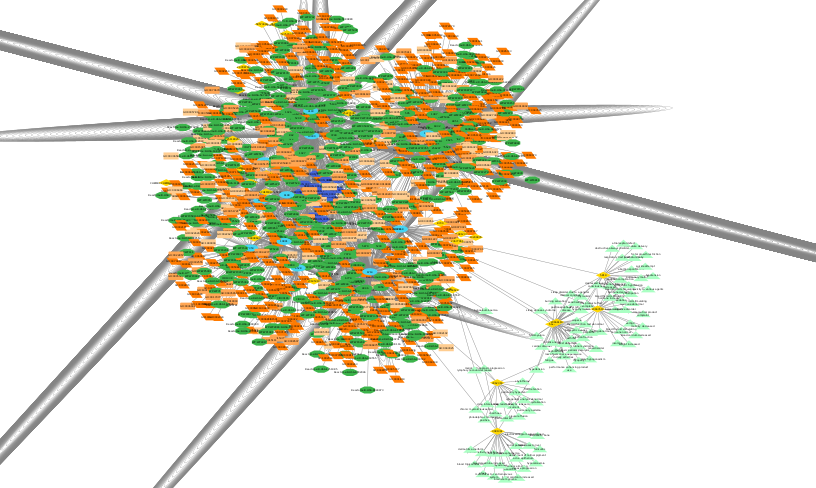

In [40]:
import py4cytoscape as p4c

p4c.notebook_export_show_image()

#### 8.4. Neo4j

In [30]:
from pyBiodatafuse.graph import neo4j

neo4j.save_graph_to_graphml(pygraph, "networkx_graph_test.graphml")

##### Steps to load the graph in Neo4j

- Add `.graphml` file in **import** subfolder of the DBMS folder
- Install apoc plugin
- Create `apoc.conf` file:
    ```
    apoc.trigger.enabled=true
    apoc.import.file.enabled=true
    apoc.export.file.enabled=true
    apoc.import.file.use_neo4j_config=true
    ```
- Add `apoc.conf` file to **conf** subfolder of the DBMS folder
- Open Neo4j Browser
- (Optionl, only run if you have imported a graph  before) Remove all the nodes before importing `.graphml` file

    ```MATCH (n) DETACH DELETE n```

- Import `.graphml` file

    ```call apoc.import.graphml('file:///networkx_graph_test.graphml',{readLabels:TRUE})```

- Add indexes after importing the graph for improving the performance of queries

    ```
    create index Gene for (n:Gene) on (n.node_type)
    create index Pathway for (n:Pathway) on (n.node_type)
    create index `Biological Process` for (n:`Biological Process`) on (n.node_type)
    create index `Molecular Function` for (n:`Molecular Function`) on (n.node_type)
    create index `Cellular Component` for (n:`Cellular Component`) on (n.node_type)
    create index Disease for (n:Disease) on (n.node_type)
    create index Compound for (n:Compound) on (n.node_type)
    create index `Side Effect` for (n:`Side Effect`) on (n.node_type)
    ```
    

- Count the number of each node type
    - total (```MATCH (n) RETURN count(n)```) 
        - Gene (```MATCH (n:Gene) RETURN count(n)```)
        - Pathway (```MATCH (n:Pathway) RETURN count(n)```)
            - WikiPathways (```MATCH (n:Pathway {source: "WikiPathways"}) RETURN count(n)```) 
            - OpenTargets, Reactome (```MATCH (n:Pathway {source: "OpenTargets"}) RETURN count(n)```) 
            - MINERVA (```MATCH (n:Pathway {source: "MINERVA"}) RETURN count(n)```) 
        - Biological Process (```MATCH (n:`Biological Process`) RETURN count(n)```) 
        - Molecular Function (```MATCH (n:`Molecular Function`) RETURN count(n)```) 
        - Cellular Component (```MATCH (n:`Cellular Component`) RETURN count(n)```) 
        - Disease (```MATCH (n:Disease) RETURN count(n)```) 
        - Compound (```MATCH (n:Compound) RETURN count(n)```)
        - Side Effect (```MATCH (n:`Side Effect`) RETURN count(n)```) 
- Count the number of each edge type
    - total (```MATCH ()-[r]->() RETURN count(r)```) 
        - interacts_with (```MATCH ()-[r:interacts_with]->() RETURN count(r)```) 
        - part_of (```MATCH ()-[r:part_of]->() RETURN count(r)```) 
            - WikiPathways (```MATCH ()-[r:part_of {source: "WikiPathways"}]->() RETURN count(r)```) 
            - OpenTargets, Reactome (```MATCH ()-[r:part_of {source: "OpenTargets"}]->() RETURN count(r)```) 
            - MINERVA (```MATCH ()-[r:part_of {source: "MINERVA"}]->() RETURN count(r)```) 
        - activates (```MATCH ()-[r:activates]->() RETURN count(r)```) 
        - treats (```MATCH ()-[r:treats]->() RETURN count(r)```) 
        - has_side_effect (```MATCH ()-[r:has_side_effect]->() RETURN count(r)```) 
        - inhibits (```MATCH ()-[r:inhibits]->() RETURN count(r)```) = 71
        - associated_with (```MATCH ()-[r:associated_with]->() RETURN count(r)```) 

- Export the graph as a `.csv` file

    ```call apoc.export.csv.all("networkx_graph_test.csv",{})```

#### 8.5. RDF

In [31]:
# Instantiate a BDFGraph
bdf = BDFGraph(
    base_uri="https://biodatafuse.org/example/",
    version_iri="https://biodatafuse.org/example/test.owl",
    orcid="https://orcid.org/0000-0002-4166-7093",
    author="Javier Millan Acosta",
)

bdf.generate_rdf(combined_df, combined_metadata)  # Generate the RDF from the (meta)data

Building RDF graph:   0%|          | 0/11 [00:00<?, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
bdf.serialize(
    os.path.join(
        base_dir,
        "examples",
        "data",
        "gene_to_graph_workflow" "gene_to_graph_workflow",
        "BDF_example_graph.ttl",
    ),
    format="ttl",
)

##### 8.5.1. Generate prefixes SHACL

SHACL graphs defining namespaces and prefixes can be loaded into SPARQL endpoints to avoid having to declare prefixes in the query.

In [ ]:
# Use without parameters (defaults, does not save file)
bdf.shacl_prefixes()
# or Use with parameters
bdf.shacl_prefixes(
    path=os.path.join(
        base_dir,
        "examples",
        "data",
        "gene_to_graph_workflow" "gene_to_graph_workflow",
        "BDF_prefixes.ttl",
    ),
    namespaces=None,  # Optional, add more namespaces with a dictionary of {prefix:namespace,}
)

##### 8.5.2. Use [`shexer`](https://github.com/DaniFdezAlvarez/shexer/) to retrieve the RDF shapes

The `shexer` library is used to retrieve the shapes of the graph in SHACL (https://www.w3.org/TR/shacl/) and ShEx (https://shex.io/shex-semantics/).

- **SHACL**

In [ ]:
# Use without parameters (defaults)
# bdf.shacl()

# Or use with parameters
bdf.shacl(
    path=os.path.join(
        base_dir,
        "examples",
        "data",
        "gene_to_graph_workflow" "gene_to_graph_workflow",
        "BDF_example_shacl.ttl",
    ),  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=os.path.join(
        base_dir,
        "examples",
        "data",
        "gene_to_graph_workflow" "gene_to_graph_workflow",
        "BDF_example_shacl.png",
    ),  # Set a path for diagram
)

# Display the UML figure
display(
    Image(
        os.path.join(
            base_dir,
            "examples",
            "data",
            "gene_to_graph_workflow" "gene_to_graph_workflow",
            "BDF_example_shacl.png",
        )
    )
)

- **ShEx**

In [ ]:
# Use without parameters (defaults)
# bdf.shex()

# Or use with parameters
bdf.shex(
    path=os.path.join(
        base_dir,
        "examples",
        "data",
        "gene_to_graph_workflow" "gene_to_graph_workflow",
        "BDF_example_shex.ttl",
    ),  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=os.path.join(
        base_dir,
        "examples",
        "data",
        "gene_to_graph_workflow" "gene_to_graph_workflow",
        "BDF_example_shex.png",
    ),  # Set a path for diagram
)

# Display the UML figure
display(
    Image(
        os.path.join(
            base_dir,
            "examples",
            "data",
            "gene_to_graph_workflow" "gene_to_graph_workflow",
            "BDF_example_shex.png",
        )
    )
)

Elapsed time for the workflow, if ran in block:

In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time
hours = elapsed_time // 3600
minutes = (elapsed_time % 3600) // 60
seconds = elapsed_time % 60
milliseconds = (elapsed_time % 1) * 1000

# Display elapsed time in h:m:s:ms
print(f"Elapsed Time: {int(hours)}h {int(minutes)}m {int(seconds)}s {int(milliseconds)}ms")

##### 8.5.3 Set up a virtuoso endpoint to query the RDF graph

[This repository](https://github.com/jmillanacosta/fast-virtuoso) provides a quick way to set up a local Virtuoso endpoint using its docker image.

Upload the prefixes (`bdf.shacl_prefixes(path="your/path")`) and the BDF graph generated above (`bdf.serialize("your/path", format="ttl")`).

In [ ]:
# Define a function to send some sample SELECT queries and return the response in a pandas DataFrame
import requests


def send_sparql_query(query, endpoint="http://localhost:8899/sparql", format="text/csv"):
    headers = {"Accept": format}
    params = {"query": query}
    response = requests.get(endpoint, headers=headers, params=params)

    # Check if request was successful
    if response.status_code == 200:
        if format == "text/csv":
            # Convert CSV response to pandas DataFrame
            from io import StringIO

            csv_data = StringIO(response.text)
            return pd.read_csv(csv_data)
        else:
            return response.text  # For other formats if needed
    else:
        raise Exception(f"Query failed with status code {response.status_code}: {response.text}")

In [ ]:
from rdflib import RDF, RDFS, SH, Graph

# Parse the query graph
# Load the graph
query_g = Graph()
with open("examples/SPARQL/queries.ttl", "r") as f:
    query_g.parse(f, format="turtle")

# Extract queries and comments into a list of dictionaries
queries_list = []
for s in query_g.subjects(RDF.type, SH.SPARQLSelectExecutable):
    query_text = query_g.value(s, SH.select)
    comment = query_g.value(s, RDFS.comment)

    if query_text and comment:
        # Append a dictionary for each query and its comment
        queries_list.append({"comment": comment.value, "query": query_text.value})

In [ ]:
query_0 = send_sparql_query(queries_list[0]["query"])
print(queries_list[0]["comment"])
print(queries_list[0]["query"])
query_0

In [ ]:
query_3 = send_sparql_query(queries_list[3]["query"])
print(queries_list[3]["query"])
print(queries_list[3]["comment"])
query_3